In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import csv
import pandas as pd
import os

gpu_id = "2"

titles = {
    "imagenet":        "ImageNet Validation Set",
    "objectnet":       "ObjectNet",
    "laionet":         "LAIONet (subset of LAION400m)",
    "math":            "Math",
    "mmlu":            "MMLU",
    "bbh":             "BBH",
    "musr":            "MUSR",
    "gpqa":            "GPQA",
}

def load_csv(file_name):
    with open(file_name, 'r') as f:
        csv_reader = csv.reader(f,delimiter=',')
        return list(csv_reader)
    
# load bars bars
bar_data = {}
for task in tqdm(titles, desc="loading files ..."):
    npy_path = f'bars/{task}.npy'
    if not os.path.exists(npy_path):
        continue
    if task.split('_')[-1]=="sim":
        bar_data[task] = {"bar": np.load(npy_path)>0.6}
    else:
        data = {"bar": np.load(npy_path)>0.6}
        models_csv = f'bars/{task}_models.csv'
        examples_csv = f'bars/{task}_examples.csv'
        if os.path.exists(models_csv):
            data["models"] = load_csv(models_csv)
        if os.path.exists(examples_csv):
            data["examples"] = load_csv(examples_csv)
        bar_data[task] = data
    bar = bar_data[task]['bar']
    bar[np.isnan(bar)] = 0

loading files ...: 100%|██████████| 8/8 [00:00<00:00, 14.42it/s]


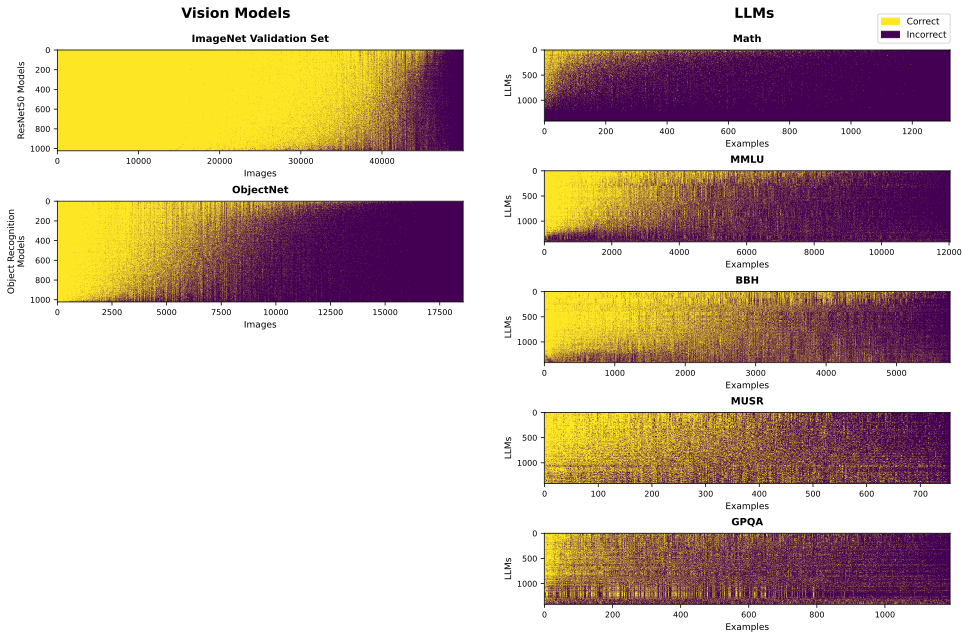

In [2]:
# create figure 2

%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.patches as mpatches

# Example tasks
base_vision = ["imagenet", "objectnet", "laionet"]
vision_tasks = [t for t in base_vision if t in bar_data]
llm_tasks = [t for t in ["math", "mmlu", "bbh", "musr", "gpqa"] if t in bar_data]

fig = plt.figure(figsize=(16, 10), dpi=300)

# Top-level GridSpec: 1 row, 2 columns
outer_gs = gridspec.GridSpec(nrows=1, ncols=2, figure=fig,
                             width_ratios=[1, 1], wspace=0.2)

# Left column (Vision): 4 rows
left_gs = gridspec.GridSpecFromSubplotSpec(
    nrows=4, ncols=1,
    subplot_spec=outer_gs[0],
    height_ratios=[1, 1, 1, 1],
    hspace=0.5
)

# Right column (LLMs): 5 rows
right_gs = gridspec.GridSpecFromSubplotSpec(
    nrows=5, ncols=1,
    subplot_spec=outer_gs[1],
    height_ratios=[0.75, 0.75, 0.75, 0.75, 0.75],
    hspace=0.7
)

viridis_cmap = mpl.colormaps.get_cmap("viridis")
color_0 = viridis_cmap(0.0)
color_1 = viridis_cmap(1.0)

# Create legend patches
patch_0 = mpatches.Patch(color=color_1, label="Correct")
patch_1 = mpatches.Patch(color=color_0, label="Incorrect")


# We'll create the legend at the figure level (so it doesn’t belong to one subplot).
# You can control its position with bbox_to_anchor.
fig.legend(
    handles=[patch_0, patch_1],
    loc="upper right",
    bbox_to_anchor=(0.90, 0.93),    # (x, y) coordinates in figure fraction
    borderaxespad=0.0,
    fontsize=9,
    title_fontsize=11
)

# Large column headings
fig.text(
    0.28, 0.93, "Vision Models", 
    ha="center", va="center", 
    fontsize=14, fontweight="bold"
)
fig.text(
    0.73, 0.93, "LLMs", 
    ha="center", va="center", 
    fontsize=14, fontweight="bold"
)
########################
# VISION MODELS (left)
########################
for i, task in enumerate(vision_tasks):
    ax = fig.add_subplot(left_gs[i])
    bar = bar_data[task]['bar']
    im = ax.imshow(bar, interpolation="nearest", aspect="auto", 
                   cmap="viridis", vmin=0, vmax=1)
    
    ax.set_title(titles[task], fontsize=10, fontweight="bold", pad=8)
    ax.set_xlabel("Images", fontsize=9)
    
    if i == 0:
        ax.set_ylabel("ResNet50 Models", fontsize=9)
    else:
        ax.set_ylabel("Object Recognition\nModels", fontsize=9)

    ax.tick_params(labelsize=8)
    ax.grid(False)

########################
# LLMs (right)
########################
for i, task in enumerate(llm_tasks):
    ax = fig.add_subplot(right_gs[i])
    bar = bar_data[task]['bar']
    im = ax.imshow(bar, interpolation="nearest", aspect="auto", 
                   cmap="viridis", vmin=0, vmax=1)
    
    ax.set_title(titles[task], fontsize=10, fontweight="bold", pad=8)
    ax.set_xlabel("Examples", fontsize=9)
    ax.set_ylabel("LLMs", fontsize=9)

    ax.tick_params(labelsize=8)
    ax.grid(False)
    
plt.savefig('figures/fig2.svg')
plt.show()

In [ ]:
# Fuzzy binary-search accuracy estimation (ImageNet)
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Configuration
NEIGHBORS = 10  # use 10 nearest neighbors (5 before, 5 after)


def fuzzy_check_neighborhood(row: np.ndarray, idx: int, neighbors: int = NEIGHBORS) -> float:
    """
    Returns the mean correctness of the nearest `neighbors` elements around `idx`,
    excluding the center index itself (split half before, half after).
    If there are fewer available near edges, uses what's available.
    Falls back to the value at idx if no neighbors exist.
    """
    n = row.shape[0]
    half = neighbors // 2
    left_start = max(0, idx - half)
    left_end = idx  # exclusive
    right_start = idx + 1
    right_end = min(n, idx + 1 + half)

    vals = []
    if left_start < left_end:
        vals.append(row[left_start:left_end])
    if right_start < right_end:
        vals.append(row[right_start:right_end])
    if len(vals) == 0:
        return float(row[idx])
    window = np.concatenate(vals, axis=0)
    return float(window.mean())


def estimate_accuracy_row_binary_search(row: np.ndarray, neighbors: int = NEIGHBORS) -> float:
    """
    Estimate accuracy for a single model row of booleans via binary search:
    - Assume the row transitions from mostly True to mostly False as difficulty increases.
    - At a probe index, compute the mean correctness of the nearest `neighbors` entries.
    - If mean > 0.5, move right (toward harder examples); else move left.
    - The cutoff index (last index with mean>0.5) yields accuracy ≈ (cutoff+1)/N.
    """
    n = row.shape[0]
    low, high = 0, n - 1
    best_true_idx = -1
    while low <= high:
        mid = (low + high) // 2
        local_mean = fuzzy_check_neighborhood(row, mid, neighbors)
        if local_mean > 0.5:
            best_true_idx = mid
            low = mid + 1
        else:
            high = mid - 1
    return (best_true_idx + 1) / n if best_true_idx >= 0 else 0.0


# Run for ImageNet
if 'imagenet' in bar_data and 'bar' in bar_data['imagenet']:
    B = (bar_data['imagenet']['bar'] > 0).astype(np.uint8)  # shape: [num_models, num_images]
    num_models = B.shape[0]

    est_acc = np.zeros(num_models, dtype=np.float64)
    true_acc = B.mean(axis=1)

    for i in tqdm(range(num_models), desc='Estimating accuracies (ImageNet)'):
        est_acc[i] = estimate_accuracy_row_binary_search(B[i].astype(np.uint8), neighbors=NEIGHBORS)

    # Plot estimated vs true accuracies
    plt.figure(figsize=(4, 4), dpi=150)
    plt.scatter(true_acc, est_acc, s=10, alpha=0.6)
    lims = [0, 1]
    plt.plot(lims, lims, 'k--', linewidth=1)  # y = x reference
    plt.xlim(lims)
    plt.ylim(lims)
    plt.xlabel('True accuracy')
    plt.ylabel('Estimated accuracy (fuzzy binary search)')
    plt.title('ImageNet: Estimated vs True Accuracies (per model)')
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()
else:
    print('ImageNet data not available in bar_data.')


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:08<00:00,  1.42it/s]

tasks ['MATH', 'MMLU', 'BBH', 'MUSR', 'GPQA']
POC_real [0.162242, 0.25927, 0.354184, 0.355957, 0.450512]
POC_random [0.000772, 0.000784, 0.001487, 0.00087, 0.000927]


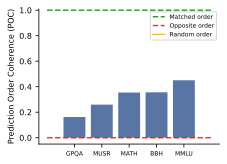

tasks ['ImageNet', 'Res Pop\nImageNet', 'ObjectNet', 'LaioNet']
POC_real [0.610028, 0.733235, 0.750345, 0.769888]
POC_random [0.000975, 0.001191, 0.001148, 0.009703]


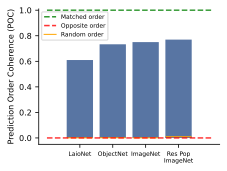

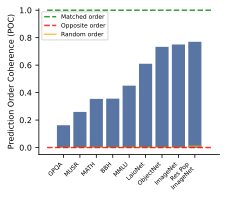

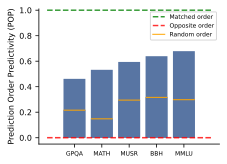

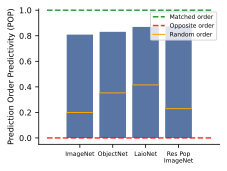

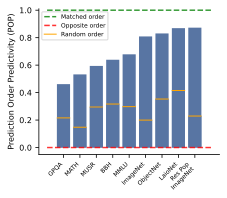

In [ ]:
# Compute and plot POP

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import os
os.environ["CUDA_VISIBLE_DEVICES"] = gpu_id 

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('default')
sns.reset_defaults()
mpl.rcParams['font.size'] = 8
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['axes.titlesize'] = 8
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['legend.fontsize'] = 6
mpl.rcParams['legend.title_fontsize'] = 8

@jax.jit
def leave_one_out_predictability_per_model(M):
    """
    Computes leave-one-out predictability metrics for each model (row) in the binary matrix M.
    
    The function first globally sorts the columns (examples) using:
      - Primary key: the sum of values in the column (number of ones).
      - Secondary key: the weighted column sum (dot product with model accuracies).
      
    Then for each model it computes:
      - Model accuracy (mean response).
      - Expected number of correct examples (rounded from accuracy * total examples).
      - An ideal binary pattern where the first n_correct entries are ones and the rest zeros.
      - MPPA: the agreement between the model's responses and the ideal pattern.
      - Opp: the minimal agreement obtained by cyclically shifting the ideal pattern.
      - A random baseline value.
    
    Returns:
      mppa_vals: Array of MPPA (raw agreement) values per model.
      opp_vals: Array of worst-case (opposite) agreement values per model.
      rand_vals: Array of random baseline values per model.
      model_accuracies: Array of model accuracies (mean row values).
    """
    N_models, N_examples = M.shape
    acc = jnp.mean(M, axis=1)
    col_sums = jnp.sum(M, axis=0)
    weighted_col_sums = jnp.dot(acc, M)
    sorted_cols = jnp.lexsort((-weighted_col_sums, -col_sums))
    M = M[:, sorted_cols]

    def compute_opposite_pattern(test, ideal_pattern, max_shifts=1000):
        n = ideal_pattern.shape[0]
        shifts = jnp.linspace(0, n - 1, max_shifts, dtype=jnp.int32) if n > max_shifts else jnp.arange(n)
        num_shifts = max_shifts if n > max_shifts else n
        def body_fun(i, state):
            best_agreement, best_shift = state
            shift = shifts[i]
            shifted = jnp.roll(ideal_pattern, shift)
            agreement = jnp.mean(test == shifted)
            return jax.lax.cond(
                agreement < best_agreement,
                lambda _: (agreement, shift),
                lambda _: (best_agreement, best_shift),
                operand=None
            )
        init_state = (jnp.inf, 0)
        best_agreement, best_shift = jax.lax.fori_loop(0, num_shifts, body_fun, init_state)
        best_pattern = jnp.roll(ideal_pattern, best_shift)
        return best_pattern, best_agreement

    def compute_metrics(i):
        a_i = jnp.mean(M[i])
        n_correct = jnp.rint(a_i * N_examples).astype(jnp.int32)
        ideal_pattern = (jnp.arange(N_examples) < n_correct).astype(jnp.int32)
        mppa = jnp.mean((M[i] == ideal_pattern).astype(jnp.float32))
        _, opp = compute_opposite_pattern(M[i], ideal_pattern)
        rand_val = a_i * a_i + (1 - a_i) * (1 - a_i)
        return mppa, opp, rand_val

    indices = jnp.arange(N_models)
    mppa_vals, opp_vals, rand_vals = jax.vmap(compute_metrics)(indices)
    model_accuracies = jnp.mean(M, axis=1)
    return mppa_vals, opp_vals, rand_vals, model_accuracies

def get_predictability_results(bar_data):
    """
    For each task in bar_data, computes leave-one-out predictability metrics (via leave_one_out_predictability_per_model)
    and aggregates the averaged results into a dictionary.
    
    For each task, the following averages are computed:
      - mppa_avg: average raw agreement (MPPA) across models
      - opp_avg: average worst-case (opposite) agreement across models
      - rand_avg: average random baseline across models
      - avg_model_acc: average model accuracy across models
    
    Normalized predictability is defined as:
         norm_val = (mppa_avg - opp_avg) / (1 - opp_avg)
    (and similarly for the random baseline).
    
    Returns a dictionary mapping each task key to a tuple:
         (normalized_predictability, normalized_random_baseline, avg_model_accuracy)
    """
    out = {}
    for task, info in bar_data.items():
        if "bar" not in info or info["bar"].size == 0:
            continue
        M_np = (info["bar"] > 0).astype(np.int32)
        if M_np.shape[0] < 2:
            continue
        M = jnp.array(M_np)
        mppa_vals, opp_vals, rand_vals, model_acc = leave_one_out_predictability_per_model(M)
        mppa_avg = jnp.mean(mppa_vals)
        opp_avg = jnp.mean(opp_vals)
        rand_avg = jnp.mean(rand_vals)
        avg_model_acc = jnp.mean(model_acc)
        norm_val = jnp.where(jnp.abs(1 - opp_avg) < 1e-12, jnp.nan, (mppa_avg - opp_avg) / (1 - opp_avg))
        rand_norm = jnp.where(jnp.abs(1 - opp_avg) < 1e-12, jnp.nan, (rand_avg - opp_avg) / (1 - opp_avg))
        out[task] = (float(norm_val), float(rand_norm), float(avg_model_acc), mppa_vals, opp_vals, rand_vals, model_acc)
    return out

def display_label(task_key):
    """
    Formats a task key for display.
    
    - For LLM tasks (math, mmlu, bbh, musr, gpqa), the label is in uppercase.
    - For vision tasks, specific formatting is applied.
    """
    llm_tasks = ["math", "mmlu", "bbh", "musr", "gpqa"]
    if task_key in llm_tasks:
        return task_key.upper()
    elif task_key == "imagenet":
        return "ImageNet"
    elif task_key == "objectnet":
        return "ObjectNet"
    elif task_key == "laionet":
        return "LaioNet"
    else:
        return task_key

def plot_POP_bar_plot(poc_vals):
    """
    Produces bar plots of Prediction Order Predictivity (POP) using the aggregated poc_vals.
    
    poc_vals is a dictionary mapping task keys to tuples:
         (normalized_predictability, normalized_random_baseline, avg_model_accuracy)
    
    Two sets of plots are generated:
      - Separate single-figure plots for LLM tasks and vision tasks.
      - A combined figure including all tasks.
    """
    llm_tasks = [t for t in ["math", "mmlu", "bbh", "musr", "gpqa"] if t in poc_vals]
    vision_tasks = [t for t in ["imagenet", "objectnet", "laionet"] if t in poc_vals]

    for current_task_list in [llm_tasks, vision_tasks]:
        fig, ax = plt.subplots(figsize=(3.25, 3.25))
        x_labels = [display_label(x) for x in current_task_list]
        y = [poc_vals[x][0] for x in current_task_list]
        y_rand = [poc_vals[x][1] for x in current_task_list]
        combined = list(zip(x_labels, y, y_rand))
        combined.sort(key=lambda x: x[1])
        x_labels_sorted, y_sorted, y_rand_sorted = zip(*combined)
        sns.barplot(x=list(x_labels_sorted), y=list(y_sorted), color='#4B72B0', ax=ax)
        ax.hlines(1.0, -1, len(x_labels), color='green', linestyles='dashed', label='Matched order', alpha=0.8)
        ax.hlines(0.0, -1, len(x_labels), color='red', linestyles='dashed', label='Opposite order', zorder=12, alpha=0.8)
        if y_rand_sorted:
            sns.barplot(x=list(x_labels_sorted), y=list(y_rand_sorted), color='#4B72B0', ax=ax, zorder=10)
            patches = ax.patches[-len(y_rand_sorted):]
            for i, patch in enumerate(patches):
                x_left, y_bottom = patch.get_xy()
                width, height = patch.get_width(), patch.get_height()
                x_right = x_left + width
                y_top = y_bottom + height
                ax.plot([x_left+0.02, x_right-0.02], [y_top, y_top],
                        color='orange', linewidth=1, label='Random order' if i == 0 else "", zorder=11)
        plt.ylim(-0.05, 1.01)
        plt.ylabel("Prediction Order Predictivity (POP)")
        plt.xlabel("")
        plt.legend()
        sns.despine()
        plt.subplots_adjust(bottom=0.30)
        plt.show()

    current_task_list = llm_tasks + vision_tasks
    x_labels = [display_label(x) for x in current_task_list]
    y = [poc_vals[x][0] for x in current_task_list]
    y_rand = [poc_vals[x][1] for x in current_task_list]
    combined = list(zip(x_labels, y, y_rand))
    combined.sort(key=lambda x: x[1])
    x_labels_sorted, y_sorted, y_rand_sorted = zip(*combined)
    fig, ax = plt.subplots(figsize=(3.25, 3.5))
    sns.barplot(x=list(x_labels_sorted), y=list(y_sorted), color='#4B72B0', ax=ax)
    ax.hlines(1.0, -1, len(x_labels_sorted), color='green', linestyles='dashed', label='Matched order', alpha=0.8)
    ax.hlines(0.0, -1, len(x_labels_sorted), color='red', linestyles='dashed', label='Opposite order', zorder=12, alpha=0.8)
    if y_rand_sorted:
        sns.barplot(x=list(x_labels_sorted), y=list(y_rand_sorted), color='#4B72B0', ax=ax, zorder=10)
        patches = ax.patches[-len(y_rand_sorted):]
        for i, patch in enumerate(patches):
            x_left, y_bottom = patch.get_xy()
            width, height = patch.get_width(), patch.get_height()
            x_right = x_left + width
            y_top = y_bottom + height
            ax.plot([x_left+0.02, x_right-0.02], [y_top, y_top],
                    color='orange', linewidth=1, label='Random order' if i == 0 else "", zorder=11)
    plt.ylim(-0.05, 1.01)
    plt.ylabel("Prediction Order Predictivity (POP)")
    plt.xlabel("")
    ax.legend(loc='upper left')
    sns.despine()
    plt.xticks(rotation=45, ha='right')
    plt.subplots_adjust(bottom=0.30)
    plt.savefig('figures/fig3b.svg')
    plt.show()

def plot_predictability_vs_model_accuracy_for_each_task_from_out(out):
    """
    For each task in out, computes per-model leave-one-out predictability metrics
    and generates a scatter plot comparing model accuracy with normalized predictability.

    Normalized predictability is defined as:
         (MPPA - Opp) / (1 - Opp)
    mapping the worst-case agreement to 0 and perfect agreement to 1.

    The input `out` is a dictionary where each key is a task name and each value is a tuple 
    or list containing several arrays (the fourth, fifth, sixth, and seventh elements are 
    expected to be mppa_vals, opp_vals, rand_vals, and model_acc, respectively).
    """
    n_tasks = len(out)
    # Determine grid dimensions: here we use a square-like layout.
    n_cols = int(np.ceil(np.sqrt(n_tasks)))
    n_rows = int(np.ceil(n_tasks / n_cols))

    # Create subplots with a size proportional to the grid dimensions.
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
    
    # Ensure that axes is a flat array for easy iteration.
    # If there's only one subplot, wrap it in a list.
    if n_tasks == 1:
        axes = [axes]
    else:
        axes = np.array(axes).flatten()

    # Iterate over each task and its associated data.
    for ax, (task, data) in zip(axes, out.items()):
        # Unpack data: assuming the data structure contains at least 7 elements.
        _, _, _, mppa_vals, opp_vals, rand_vals, model_acc = data

        # Compute normalized predictability.
        norm_predictability = (mppa_vals - opp_vals) / (1 - opp_vals)

        # Convert values to NumPy arrays (in case they are JAX arrays or similar).
        model_acc_np = np.array(model_acc)
        norm_np = np.array(norm_predictability)
        mppa_np = np.array(mppa_vals)

        # Plot both normalized predictability and raw MPPA on the same axes.
        ax.scatter(model_acc_np, norm_np, alpha=0.6, label="Normalized Predictability",
                   s=12, linewidth=0)
        ax.scatter(model_acc_np, mppa_np, alpha=0.6, label="Raw Agreement (MPPA)",
                   marker="x", s=12)
        
        # Label the axes and set title.
        ax.set_xlabel("Model Accuracy (mean row value)")
        ax.set_ylabel("Leave-One-Out Empirical Accuracy")
        ax.set_title(f"Task: {task}")
        ax.legend()
        ax.grid(True)
        ax.set_ylim(0, 1)
        sns.despine()

    # Hide any unused subplots.
    for i in range(len(out), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
    

out = get_predictability_results(bar_data)
plot_POP_bar_plot(out)
plot_predictability_vs_model_accuracy_for_each_task_from_out(out)

In [5]:
# Compute top_n examples
import numpy as np
import pandas as pd

# llm_pred = pd.read_parquet('llm_predictions_raw/meta_llama_Meta_Llama_3_1_70B_Instruct.parquet')

# t = llm_pred[llm_pred['task_name']=='mmlu_pro']
#t[t['doc_id'] ==6764]['doc'].iloc[0]

b = bar_data['imagenet']['bar']
examples = bar_data['imagenet']['examples'][0]

# Compute the matched_bar logic
matched_bar = np.zeros_like(b)
n = len(b)
avg_accuracies = np.mean(b, axis=0)
for i, x in enumerate(avg_accuracies):
    matched_bar[:int(round(n * x)), i] = 1

# Compute violation counts
violation_counts = np.sum(np.logical_xor(b, matched_bar), axis=0)

start = 0
end = b.shape[1]  # or len(bar_data['imagenet']['bar'][0])

# Define 20% bins in [0,1]
range_bins = [(0.0, 0.33), (0.33, 0.66), (0.66, 1.00)]

results = {}

for (low, high) in range_bins:
    # Indices within the specified average accuracy range
    idx_in_range = np.where(
        (avg_accuracies >= low) & (avg_accuracies < high)
    )[0]
    
    if len(idx_in_range) == 0:
        # No examples in this accuracy range
        results[(low, high)] = []
        continue
    
    # Extract violation counts for this subset
    subset_violations = violation_counts[idx_in_range]
    
    # Identify top 10 indices by violation count
    # (argsort -> ascending, so we take the last 10 and reverse)
    top_n_idx = np.argsort(subset_violations)[-10:][::-1]
    
    top_n_examples = []
    for ti in top_n_idx:
        global_idx = idx_in_range[ti]  # Map back to the full index
        acc = round(avg_accuracies[global_idx]*100, 2)
        
        # Build the display or data structure as in your original code
        example_path = examples[global_idx + start]
        # Example: "/class_name/file_name.jpg" → keep parts of the path
        short_name = '/'.join(example_path.split('/')[-2:])[:-9]
        
        # top_n_examples.append((
        #     short_name,
        #     global_idx + start,
        #     violation_counts[global_idx],
        #     acc,
        #     eval(t[t['doc_id'] ==int(short_name)]['doc'].iloc[0]),
        # ))
        top_n_examples.append((
            short_name,
            global_idx + start,
            violation_counts[global_idx],
            acc,
            #eval(t[t['doc_id'] ==int(short_name)]['doc'].iloc[0]),
        ))
    
    # Store results for this bin range
    results[(low, high)] = top_n_examples

# Now you can print or otherwise use the results
for (low, high), top_examples in results.items():
    print(f"Average accuracy range {low*100:.0f}-{high*100:.0f}%:")
    if not top_examples:
        print("  No examples in this range.")
        continue
    
    for ex in top_examples:
        print("  ", ex)

Average accuracy range 0-33%:
   ('n02974003/ILSVRC2012_val_00002405.JPEG', 43517, 666, 32.94)
   ('n01871265/ILSVRC2012_val_00007884.JPEG', 43711, 598, 31.18)
   ('n02504013/ILSVRC2012_val_00014681.JPEG', 43689, 582, 31.38)
   ('n03485794/ILSVRC2012_val_00047363.JPEG', 43975, 564, 28.84)
   ('n02823750/ILSVRC2012_val_00042562.JPEG', 43687, 564, 31.38)
   ('n04435653/ILSVRC2012_val_00020316.JPEG', 44026, 564, 28.25)
   ('n03146219/ILSVRC2012_val_00006706.JPEG', 43746, 558, 30.89)
   ('n02894605/ILSVRC2012_val_00017544.JPEG', 43556, 550, 32.55)
   ('n07747607/ILSVRC2012_val_00013588.JPEG', 43851, 548, 30.01)
   ('n02749479/ILSVRC2012_val_00012413.JPEG', 43781, 546, 30.6)
Average accuracy range 33-66%:
   ('n07892512/ILSVRC2012_val_00024477.JPEG', 41167, 806, 53.67)
   ('n02106166/ILSVRC2012_val_00049942.JPEG', 41461, 790, 51.22)
   ('n02412080/ILSVRC2012_val_00035280.JPEG', 41181, 770, 53.57)
   ('n03781244/ILSVRC2012_val_00003613.JPEG', 42468, 768, 42.62)
   ('n04069434/ILSVRC2012_val_

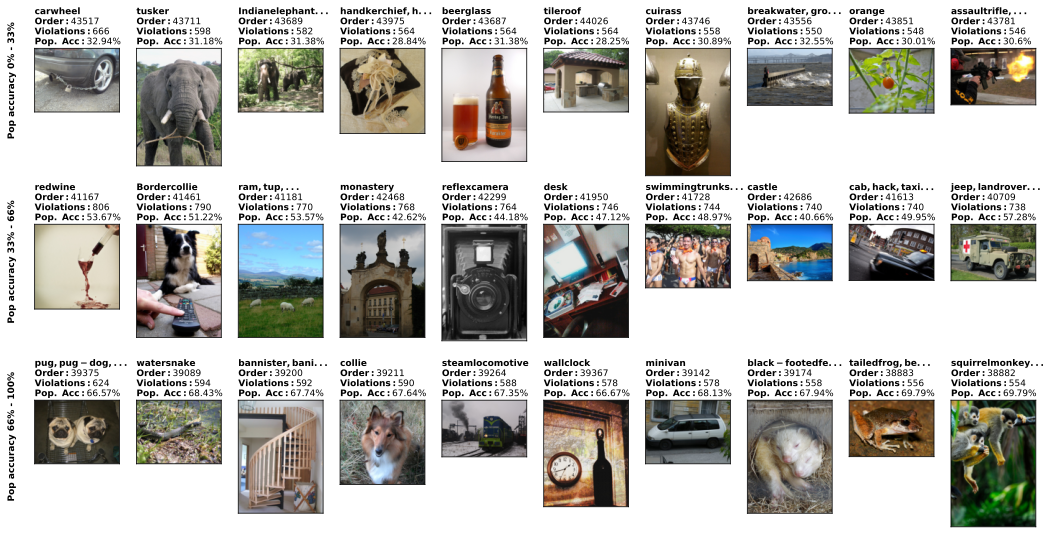

In [6]:
# Additional interpretability figure: most non-matched images
# Which imagenet images most violate the matched ordering pattern?
# This figure shows those images stratified by 3 overall accuracy ranges
# There isn't a clear trend, but possibly these images require more
# memorization of a specific detail over reasoning about a more general pattern to classify correctly

import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
import textwrap
import json
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['mathtext.fontset'] = 'dejavusans'
mpl.rcParams['mathtext.default'] = 'regular'
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 9

with open('mapping/imagenet_nid.json') as f:
    imagenet_nid = json.load(f)


imagenet_path = 'datasets/pytorch_imagenet_data/val/'

num_rows = len(results)
num_cols = len(results[list(results.keys())[0]])

# Increase the row height and let constrained_layout handle spacing
fig, axes = plt.subplots(
    nrows=num_rows, 
    ncols=num_cols, 
    figsize=(16, 3 * num_rows),
    constrained_layout=False,
    gridspec_kw={'left': 0.03}
)

# If there's only one row, `axes` won't be a 2D array.
if num_rows == 1:
    axes = [axes]

for row_idx, ((low, high), top_examples) in enumerate(results.items()):
    
    # Show the "Pop accuracy" text on the left margin. 
    # Compute a Y coordinate by stepping top to bottom across num_rows.
    low_pct = low * 100
    high_pct = high * 100
    # text_y = (1.00 - (row_idx + 0.5) / num_rows)*.9
    text_y = [.83,.55,.28][row_idx]
    #print(text_y)
    
    fig.text(
        0.01,
        text_y,
        f"Pop accuracy {low_pct:.0f}% - {high_pct:.0f}%",
        rotation=90,
        ha='center',
        va='center',
        fontsize=9,
        fontweight='bold'
    )
    
    # Plot each example in columns
    for col_idx, img_info in enumerate(top_examples):
        img_path, order_val, num_violations, col_acc = img_info
        ax = axes[row_idx][col_idx]
        
        # Read and display the image
        full_path = os.path.join(imagenet_path, img_path)
        img = Image.open(full_path)
        if img.mode in ['L', 'I']:  # single-channel modes
            img = img.convert('RGB')
        ax.imshow(img)
        
        # Remove the call to set_anchor('N'), so Matplotlib can adjust the axes height:
        ax.set_anchor('N')  # <-- remove/comment this out
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Build label text
        class_key = img_path.split('/')[0]
        class_name = imagenet_nid.get(class_key, "Unknown class")
        
        wrapped_class_name = "\n".join(textwrap.wrap(class_name, width=20))
        safe_class_name = wrapped_class_name.replace("\n", " ")
        safe_class_name = safe_class_name.split(',')
        if len(safe_class_name) >= 2:
            safe_class_name = ','.join(safe_class_name) + ", ..."
        else:
            safe_class_name = safe_class_name[0]
        if len(safe_class_name) > 18:
            safe_class_name = safe_class_name[:15] + "..."
        
        label_str = (
            f"$\\mathbf{{{safe_class_name}}}$\n"
            f"$\\mathbf{{Order:}}${order_val}\n"
            f"$\\mathbf{{Violations:}}${num_violations}\n"
            f"$\\mathbf{{Pop.~Acc:}}${col_acc}%"
        )
        
        # Increase pad so the text is lifted well above the image
        ax.set_title(label_str, loc='left', fontsize=9, pad=4)

plt.savefig('figures/fig4.svg')
plt.show()

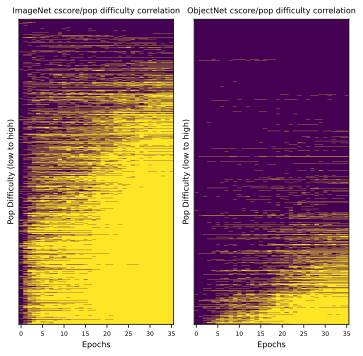

In [8]:
# figure 4, cscore vs pop difficulty ranking

import glob
import pandas as pd

%config InlineBackend.figure_format = 'svg'

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('default')
sns.reset_defaults()

#plt.style.use('ggplot')

# You can fine-tune rcParams here
import matplotlib.font_manager as fm
# for f in fm.findSystemFonts():
#     if "Times New Roman" in f:
#         print(f)
mpl.rcParams['font.size'] = 8
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['axes.titlesize'] = 8
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['legend.fontsize'] = 6
mpl.rcParams['legend.title_fontsize'] = 8
#mpl.rcParams['axes.labelweight'] = 'bold'
#mpl.rcParams['axes.linewidth'] = 1.2

# assume bar_data is defined elsewhere
pop_order_imagenet = [x.split('/')[-1][:-9] for x in bar_data['imagenet']['examples'][0]]

# 1) Identify CSV files and extract epoch from filename
preds = [
    (path, int(path.split('-')[0].split('_')[-1][2:]))
    for path in glob.glob('imagenet_resnet_cscore/*')
]
preds = sorted(preds, key=lambda x: x[1])  # sort by epoch

# 2) Read, rename column, set filenames index
dfs = []
for filepath, epoch in preds:
    df = pd.read_csv(filepath)
    df['correct'] = df['correct'].astype(int)
    df = df.rename(columns={'correct': f'correct_{epoch}'})
    df = df.set_index('filename')
    dfs.append(df)

# 3) Concatenate all dataframes by column, reset index
cscores = pd.concat(dfs, axis=1).reset_index()

pop_order_lower = [fn.lower() for fn in pop_order_imagenet]
pop_order_dict = {fn.lower(): i for i, fn in enumerate(pop_order_imagenet)}
cscores['order'] = cscores['filename'].str.lower().map(pop_order_dict)

# 3) Sort by 'order' so they appear in the same order as pop_order_imagenet
#    If you want to drop those not in pop_order_imagenet (i.e., NaNs), uncomment the dropna line.
cscores = cscores.sort_values('order', na_position='last')
# cscores = cscores.dropna(subset=['order'])

# 4) (Optional) Remove helper column
cscores_imagenet = cscores.drop(columns='order').reset_index(drop=True)


paths = glob.glob('preprocessed_respop_objectnet/*')
paths = [x for x in paths if 's100' in x and 'latest' not in x]
preds = [
    (path, int(path.split('-')[0].split('/')[-1].split('_')[-1][2:]))
    for path in paths
]
#print(preds)
preds = sorted(preds, key=lambda x: x[1])  # sort by epoch

with open('objectnet_imagenet_overlap.txt') as f:
    objectnet_imagenet_overlap = set([x[:-1] for x in f.readlines()])

dfs = []
for filepath, epoch in preds:
    df = pd.read_parquet(filepath)
    df['image'] = df['image'].apply(lambda x: x.split('/')[-1])
    df = df[df['image'].isin(objectnet_imagenet_overlap)]
    df['is_correct'] = df['is_correct'].astype(int)
    df = df.rename(columns={'is_correct': f'correct_{epoch}'})
    df = df.set_index('image')
    dfs.append(df)

# 3) Concatenate all dataframes by column, reset index
cscores = pd.concat(dfs, axis=1).reset_index()

pop_order_objectnet = [x.split('/')[-1][:-10] for x in bar_data['objectnet']['examples'][0]]

pop_order_lower = [fn.lower() for fn in pop_order_objectnet]
pop_order_dict = {fn.lower(): i for i, fn in enumerate(pop_order_objectnet)}
cscores['order'] = cscores['image'].str.lower().map(pop_order_dict)

# 3) Sort by 'order' so they appear in the same order as pop_order_imagenet
#    If you want to drop those not in pop_order_imagenet (i.e., NaNs), uncomment the dropna line.
cscores = cscores.sort_values('order', na_position='last')
# cscores = cscores.dropna(subset=['order'])

# 4) (Optional) Remove helper column
cscores_objectnet = cscores.drop(columns='order').reset_index(drop=True)


import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 5), dpi=300)

# --- First subplot (ImageNet) ---
ax1 = axes[0]
im1 = ax1.imshow(
    cscores_imagenet.to_numpy()[::-1, 1:].astype(int),
    interpolation='nearest', 
    aspect='auto', 
    cmap='viridis'
)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Pop Difficulty (low to high)")
ax1.set_title("ImageNet cscore/pop difficulty correlation")
ax1.set_yticks([])
ax1.grid(False)

# --- Second subplot (ObjectNet) ---
ax2 = axes[1]
im2 = ax2.imshow(
    cscores_objectnet.to_numpy()[::-1, 1:].astype(int),
    interpolation='nearest', 
    aspect='auto', 
    cmap='viridis'
)
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Pop Difficulty (low to high)")
ax2.set_title("ObjectNet cscore/pop difficulty correlation")
ax2.set_yticks([])
ax2.grid(False)

fig.tight_layout()

plt.savefig('figures/fig5.svg')
plt.show()

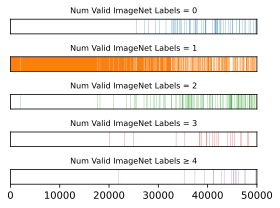

In [9]:
# Additional figure: ImageNet ReaL multilabel

# Comparing the population difficulty order with imagenet images that contain multiple labels according to imagenet ReaL
# Images with no correct labels or no correct labels tend to be more difficult
# There are still many difficult images with single correct labels

import json
import numpy as np

with open('real.json') as f:
    #real_labels = json.load(f)
    real_labels = {f'ILSVRC2012_val_{(i+1):08d}.JPEG': labels for i, labels in enumerate(json.load(f))}

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
%config InlineBackend.figure_format = 'svg'

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('default')
sns.reset_defaults()

#top_n = ['/'.join(x.split('/')[-2:])[:-9] for x in bar_data['imagenet']['examples'][0]]
pop_order = [x.split('/')[-1][:-9] for x in bar_data['imagenet']['examples'][0]]
pop_order = np.expand_dims(np.array([len(real_labels[x]) for x in pop_order]), axis=0)

# Suppose you have your pop_order array and a function to get your custom viridis 
# (if needed for something else, but we won't use it here).
# from your_module import pop_order, create_custom_viridis

# Example or placeholder pop_order (remove this if you already have pop_order):
# pop_order = np.random.randint(1,6,(10,30))

uv = np.unique(pop_order)

# Create a distinct color for each unique value using a ListedColormap or a known colormap
# Here we'll take 'tab10' and pick as many colors as needed.
# For more unique values than tab10 has, you may want to use another colormap or define your own list.
colors = plt.cm.tab10(range(len(uv)))  
value_to_color = dict(zip(uv, colors))

# Create the figure and a set of subplots, one row per unique value
fig, axes = plt.subplots(nrows=5, 
                         figsize=(4, 0.6 * 5),  # Adjust height multiplier as needed
                         dpi=300)

# If there's only one unique value, axes might not be an array, so make it a list for consistency
if len(uv) == 1:
    axes = [axes]

for i, x in enumerate(uv):
    # Define the mask for each uv
    if x == 4:
        mask = pop_order >= 4
    elif x > 4:
        # Stop if the condition is that you don't want values beyond 4
        break
    else:
        mask = (pop_order == x)
    
    # Build a two-color colormap: one for False (white), one for True (value_to_color[x])
    cmap = mcolors.ListedColormap(['white', value_to_color[x]])
    
    # Plot the mask in the i-th subplot
    im = axes[i].imshow(mask, 
                        interpolation='nearest', 
                        aspect='auto', 
                        cmap=cmap)
    
    # Disable grid, y-ticks, etc.
    axes[i].grid(False)
    axes[i].set_yticks([])
    if i!=4:
        axes[i].set_xticks([])
    axes[i].set_title(f'Num Valid ImageNet Labels = {x}' if x < 4 else 'Num Valid ImageNet Labels ≥ 4', fontsize=8)
    axes[i].set_xlim(0,50000)

# Build a legend for all values
legend_patches = []
for val in uv:
    # If you are skipping values > 4, you can conditionally add them:
    if val <= 4:
        patch = mpatches.Patch(color=value_to_color[val], label=f'{val}' if val < 4 else '≥4')
        legend_patches.append(patch)

# Place a single legend off to the right (or anywhere you prefer)
# fig.legend(handles=legend_patches, 
#            loc='upper left', 
#            bbox_to_anchor=(1.02, 1), 
#            borderaxespad=0.,
#            title='Num Valid Labels'
#           )

fig.tight_layout()
plt.savefig('figures/fig6.svg')
plt.show()

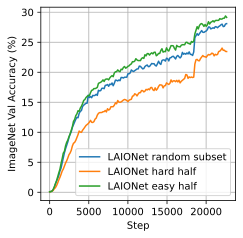

In [10]:
# Additional figure: Curriculum learning experiment:
# Training a resnet 50 from scratch on 3 population difficulty splits of  LAIONet: Easiest half, Hardest half, randomly selected half
# Training on easy images helps imagenet valset performance

import pandas as pd
import matplotlib.pyplot as plt
import os
%config InlineBackend.figure_format = 'svg'

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('default')
sns.reset_defaults()

# Load the CSV file
file_path = 'laionet_subset_training.csv'

# Check if file exists
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path}. Please check the file path and try again.")

# Read the CSV file
df = pd.read_csv(file_path)

# Ensure 'step' is the x-axis
if 'Step' not in df.columns:
    raise ValueError("The dataset must contain a 'step' column.")

# Set 'step' as the index
df.set_index('Step', inplace=True)

# Plot the data
plt.figure(figsize=(3.5, 3.5))
for column in df.columns:
    plt.plot(df.index, df[column]*100, label=column)

plt.xlabel("Step")
plt.ylabel("ImageNet Val Accuracy (%)")
plt.legend()
plt.grid()
plt.savefig('figures/fig7.svg')
plt.show()

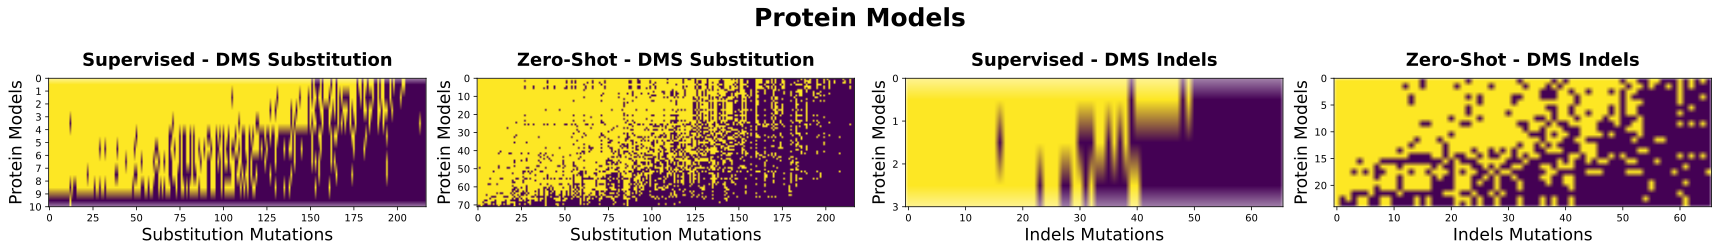

In [12]:
# Bottom of figure 2: proteins

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
%matplotlib inline
%config InlineBackend.figure_format='svg'

# ---------- Function to Process Data ----------
def process_data(filepath):
    df = pd.read_csv(filepath, index_col=0, header=0)
    df = df.transpose()
    df = df.dropna(axis=1, how='all')
    df = df.dropna(axis=0, how='all')
    model_means = df.mean(axis=1)
    sorted_models = model_means.sort_values(ascending=False).index
    assay_weights = df.sum(axis=0)
    weighted_averages = (df * assay_weights).sum(axis=0) / assay_weights.sum()
    sorted_assays = weighted_averages.sort_values(ascending=False).index
    sorted_df = df.loc[sorted_models, sorted_assays]
    return sorted_df.fillna(0).to_numpy()
# Process each dataset
data_array_subs_supervised = process_data('protein_data/DMS_subs_supervised_spearman.csv')
data_array_subs_zeroshot = process_data('protein_data/DMS_SUBS_zero-shot_Spearman.csv')
data_array_indels_supervised = process_data('protein_data/DMS_indels_supervised_spearman.csv')
data_array_indels_zeroshot = process_data('protein_data/DMS indels zero-shot spearman.csv')
# ---------- Create a single figure with 4 side-by-side subplots ----------
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(24, 3))
# ---------- Function to Set Y-axis Labels ----------
def set_integer_yticks(ax, data_array, ylabel, plot_number):
    num_rows = data_array.shape[0]
    
    if plot_number in [1, 3]:  # For the first and third plots
        # Create tick positions from before first row to after last row
        y_ticks = np.arange(-0.5, num_rows + 0.5, 1)
        # Create labels from 0 to num_rows (inclusive)
        y_labels = np.arange(0, num_rows + 1, 1)
    else:  # For other plots
        if num_rows <= 20:
            step = 1
        elif num_rows <= 50:
            step = 5
        else:
            step = 10
        y_ticks = np.arange(-0.5, num_rows - 0.5, step)
        y_labels = np.arange(0, num_rows, step)
    
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)
    ax.set_ylabel(ylabel, fontsize=17)
# ----- 1) Supervised Substitution -----
ax1 = axes[0]
im1 = ax1.imshow(data_array_subs_supervised < 0.488, cmap='viridis_r', aspect='auto', interpolation='none')
ax1.set_xlabel('Substitution Mutations', fontsize=17)
ax1.set_title('Supervised - DMS Substitution', fontsize=18, fontweight='bold', y=1.05)
set_integer_yticks(ax1, data_array_subs_supervised, "Protein Models", 1)
# ----- 2) Zero-Shot Substitution -----
ax2 = axes[1]
im2 = ax2.imshow(data_array_subs_zeroshot < 0.407, cmap='viridis_r', aspect='auto', interpolation='none')
ax2.set_xlabel('Substitution Mutations', fontsize=17)
ax2.set_title('Zero-Shot - DMS Substitution', fontsize=18, fontweight='bold', y=1.05)
set_integer_yticks(ax2, data_array_subs_zeroshot, "Protein Models", 2)
# ----- 3) Supervised Indels -----
ax3 = axes[2]
im3 = ax3.imshow(data_array_indels_supervised < 0.79, cmap='viridis_r', aspect='auto', interpolation='none')
ax3.set_xlabel('Indels Mutations', fontsize=17)
ax3.set_title('Supervised - DMS Indels', fontsize=18, fontweight='bold', y=1.05)
set_integer_yticks(ax3, data_array_indels_supervised, "Protein Models", 3)
# ----- 4) Zero-Shot Indels -----
ax4 = axes[3]
im4 = ax4.imshow(data_array_indels_zeroshot < 0.374, cmap='viridis_r', aspect='auto', interpolation='none')
ax4.set_xlabel('Indels Mutations', fontsize=17)
ax4.set_title('Zero-Shot - DMS Indels', fontsize=18, fontweight='bold', y=1.05)
set_integer_yticks(ax4, data_array_indels_zeroshot, "Protein Models", 4)
plt.tight_layout()
# ------------------- Legend -------------------
# viridis_cmap = mpl.cm.get_cmap("viridis")  # Fixed to use mpl.cm.get_cmap for compatibility
# color_0 = viridis_cmap(0.0)   # "Incorrect"
# color_1 = viridis_cmap(1.0)   # "Correct"
# patch_0 = mpatches.Patch(color=color_1, label="Correct")
# patch_1 = mpatches.Patch(color=color_0, label="Incorrect")
# fig.legend(
#     handles=[patch_0, patch_1],
#     loc="upper right",
#     bbox_to_anchor=(0.994, 1.1),
#     borderaxespad=0.0,
#     fontsize=14)

# Add the main title
fig.suptitle('Protein Models', fontweight='bold', fontsize=25, y=1.15)

plt.show()
# Save the figure
#fig.savefig('all.png', bbox_inches='tight')

#fig.savefig('protein_bar.svg', bbox_inches='tight')